In [142]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from score_neural_network import score_nn
import time
from utils import generate_phit, generate_expAt, jacobian, batched_jacobian, train_score_nn


plt.rc('font', size = 14)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [143]:
N_list = [1000] ##Number of samples
# T_list = [501, 251, 101, 51, 21, 11]## number of time steps dt = [0.002, 0.004, 0.01, 0.02, 0.05, 0.1]
T_list = [251]
n = 2 ## dimension of the state space
m = 1 ## dimension of the control space
tf = 1.0 ## terminal time

epsilon = 0.3 ## noise level

A = torch.tensor([[0.0,1.0],[0.0,0.0]])
B = torch.tensor([[0.0],[1.0]])

x_0 = torch.tensor([[0.0],[0.0]])
y = torch.tensor([[2.0],[0.0]])

# sigma_list = [0.0, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3] ##std of the terminal distribution
# sigma_list = [0.0, 0.02] ##std of the terminal distribution
sigma_list = [0.0] ##std of the terminal distribution

exp_num = 1 ## number of experiments


# MSE_record = np.zeros((len(T_list), 5, exp_num))
# u_norm_record = np.zeros((len(sigma_list),5,exp_num))
# MSE_det_record = np.zeros((len(T_list),len(sigma_list),exp_num))
dt_list = np.zeros(len(T_list))
total_exp_num = len(T_list)*exp_num*len(sigma_list)*len(N_list)

In [144]:
def generate_phit(t, n):
    """
    t shape is (T, 1), output shape is (T, n, n)
    """
    T, _ = t.shape
    phi_t = torch.zeros((T, n, n))
    phi_t[:,0,0] = t[:,0]**3/3
    phi_t[:,0,1] = t[:,0]**2/2
    phi_t[:,1,0] = t[:,0]**2/2
    phi_t[:,1,1] = t[:,0]
    return phi_t

In [145]:
for i, T in enumerate(T_list):
    t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid, shape is (T,1)
    dt = t[1] - t[0]
    dt_list[i] = dt
    exp1tAtrans = generate_expAt(A.T, tf-t)
    exp1tA = generate_expAt(A, tf-t)
    phi1t = generate_phit(tf-t, n)
    expA = generate_expAt(A, torch.ones_like(t))[0,:,:]
    phi_1 = generate_phit(torch.ones_like(t), n)
    expt1A = generate_expAt(A, t-tf)
    expt1Atrans = generate_expAt(A.T, t-tf)
    exp_minustA = generate_expAt(-A, t)
    exp_minustAtrans = generate_expAt(-A.T, t)
    phi_t = generate_phit(t, n)
    ## compute deterministic control
    # U_d = torch.einsum('tij,tjk->tik', torch.einsum('ij,tjk->tik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1)) @ (y - expA @ x_0).squeeze(-1)
    U_d = torch.einsum('tij,tjk->tik', torch.einsum('ij,tjk->tik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1)) @ (y - expA @ x_0).squeeze(-1)
    for j, sigma in enumerate(sigma_list):
        for sample_idx, N in enumerate(N_list):

            for exp in range(exp_num):
                print('starting experiment: ', exp+1, 'T: ', T, 'sigma: ', sigma, 'N: ', N)
                time_start = time.time()
                
            
                ### Generate backward samples 
                X_backward_u = torch.zeros((T, N, n))
                X_backward_u[-1,:,:] = torch.randn(N,n)*sigma + y.T
                X_backward = torch.zeros((T, N, n))
                X_backward[-1,:,:] = torch.randn(N,n)*sigma + y.T
                for k in range(T-1, 0, -1):
                    W_backward = torch.randn(N,m)*np.sqrt(dt)
                    dX_u = (A @ X_backward_u[k,:,:].T  + B @ U_d[k-1,:].repeat(N,1).T).T * dt + (B @ (epsilon * W_backward).T).T
                    X_backward_u[k-1,:,:] = X_backward_u[k,:,:] - dX_u
                    dX = (A @ X_backward[k,:,:].T).T * dt + (B @ (epsilon * W_backward).T).T
                    X_backward[k-1,:,:] = X_backward[k,:,:] - dX
                
                ## Calculate mean and covariance of the backward samples without control
                Mean_Xb = X_backward.mean(dim=1)
                Cov_Xb = torch.zeros((T, n, n))
                Mean_Xb_u = X_backward_u.mean(dim=1)
                Cov_Xb_u = torch.zeros((T, n, n))
                for k in range(T):
                    Cov_Xb[k,:,:] = torch.cov(X_backward[k,:,:].T)
                    Cov_Xb_u[k,:,:] = torch.cov(X_backward_u[k,:,:].T)

                ### initialize the neural network
                hidden_dim = 32
                learning_rate = 1e-3
                batch_size = 32
                t_batch_size = 10
                iterations = 30000 
            

                model_a = score_nn(n, m, hidden_dim)
                train_score_nn(X_backward, t, B, learning_rate, iterations, batch_size, t_batch_size, N, model_a)

                model_u = score_nn(n, m, hidden_dim)
                train_score_nn(X_backward_u, t, B, learning_rate, iterations, batch_size, t_batch_size, N, model_u)

                

                W_forward = torch.zeros((T, N, m))
                for k in range(T):
                    W_forward[k,:,:] = torch.randn(N,m)*np.sqrt(dt)
                
                X_pred_u = torch.zeros((T, N, n))## NN method with control
                X_pred_det = torch.zeros((T, N, n)) ## Deterministic 
                X_pred = torch.zeros((T, N, n)) ## NN method without control
                X_pred_sol_u = torch.zeros((T, N, n))## mean covariance approximation method
                X_pred_sol = torch.zeros((T, N, n))## exact solution
                X_pred_k_approx = torch.zeros((T, N, n))
                u1_record = torch.zeros((T, N, m))
                u2_record = torch.zeros((T, N, m))
                u3_record = torch.zeros((T, N, m))
                u4_record = torch.zeros((T, N, m))
                u5_record = torch.zeros((T, N, m))

                model_a.eval()
                model_u.eval()
                for k in range(1, T):

                    ## NN method without control
                    model_pred = model_a.forward(X_pred[k-1,:,:], t[k-1].repeat(N,1))
                    u1 = model_pred * epsilon**2
                    u1_record[k-1,:,:] = u1
                    dX_pred = (A @ X_pred[k-1,:,:].T + B @ u1.T).T * dt + (B @(epsilon * W_forward[k-1,:,:]).T).T
                    X_pred[k,:,:] = X_pred[k-1,:,:] + dX_pred
                    
                    ## NN method with control
                    model_pred_u = model_u.forward(X_pred_u[k-1,:,:], t[k-1].repeat(N,1))
                    u2 = U_d[k-1,:].repeat(N,1) + model_pred_u * epsilon**2
                    u2_record[k-1,:,:] = u2
                    dX_u = (A @ X_pred_u[k-1,:,:].T + B @ u2.T).T * dt + (B @(epsilon * W_forward[k-1,:,:]).T).T
                    X_pred_u[k,:,:] = X_pred_u[k-1,:,:] + dX_u

                    ## Exact solution without control
                    Q_1t = sigma**2 * exp_minustA[k-1,:,:]@exp_minustAtrans[k-1,:,:] + epsilon**2  * expt1A[k-1,:,:] @ phi1t[k-1,:,:] @ expt1Atrans[k-1,:,:]
                    u3 = -epsilon**2 * (X_pred_sol[k-1,:,:] - (expt1A[k-1,:,:] @ y).repeat(1,N).T) @ (B.T @ torch.linalg.pinv(Q_1t)).T
                    u3_record[k-1,:,:] = u3
                    dX_sol = (A @ X_pred_sol[k-1,:,:].T + B @ u3.T).T * dt + (B @(epsilon * W_forward[k-1,:,:]).T).T
                    X_pred_sol[k,:,:] = X_pred_sol[k-1,:,:] + dX_sol
                    
                    # Exact solution with control
                    # Q_1t = sigma**2 * exp_minustA[k-1,:,:]@exp_minustAtrans[k-1,:,:] + epsilon**2  * expt1A[k-1,:,:] @ phi1t[k-1,:,:] @ expt1Atrans[k-1,:,:]
                    # u4 = U_d[k-1,:].repeat(N,1) - epsilon**2 *(X_pred_sol[k-1,:,:] - (expt1A[k-1,:,:] @ y).repeat(1,N).T) @ (B.T @ torch.linalg.pinv(Q_1t)).T
                    # u4_record[k-1,:,:] = u4
                    # dX_sol_u = (A @ X_pred_sol_u[k-1,:,:].T + B @ u4.T).T * dt + (B @(epsilon * W_forward[k-1,:,:]).T).T
                    # X_pred_sol_u[k,:,:] = X_pred_sol_u[k-1,:,:] + dX_sol_u 
                    ## Approximation k method (without control)
                    u4 = (-(epsilon**2) * B.T @ torch.linalg.pinv(Cov_Xb[k-1,:]) @ (X_pred_k_approx[k-1,:,:] - Mean_Xb[k-1,:].repeat(N,1)).T).T #+ U_d[k-1,:].repeat(N,1)
                    dX_k_approx = (A @ X_pred_k_approx[k-1,:,:].T + B @ u4.T).T * dt + (B @(epsilon * W_forward[k-1,:,:]).T).T
                    X_pred_k_approx[k,:,:] = X_pred_k_approx[k-1,:,:] + dX_k_approx

                    ## Deterministic open loop control
                    
                    

starting experiment:  1 T:  251 sigma:  0.0 N:  1000
Iteration: 1000/30000, loss = -22.213106155396
Iteration: 2000/30000, loss = -27.764125823975
Iteration: 3000/30000, loss = -28.768409729004
Iteration: 4000/30000, loss = -32.863426208496
Iteration: 5000/30000, loss = -41.916725158691
Iteration: 6000/30000, loss = -82.216674804688
Iteration: 7000/30000, loss = -50.156322479248
Iteration: 8000/30000, loss = -79.806701660156
Iteration: 9000/30000, loss = -49.775093078613
Iteration: 10000/30000, loss = -40.754402160645
Iteration: 11000/30000, loss = -48.382286071777
Iteration: 12000/30000, loss = -27.111915588379
Iteration: 13000/30000, loss = -56.006824493408
Iteration: 14000/30000, loss = -14.091842651367
Iteration: 15000/30000, loss = -66.117187500000
Iteration: 16000/30000, loss = -59.731418609619
Iteration: 17000/30000, loss = -41.274116516113
Iteration: 18000/30000, loss = -50.591896057129
Iteration: 19000/30000, loss = -48.365207672119
Iteration: 20000/30000, loss = -94.023689270

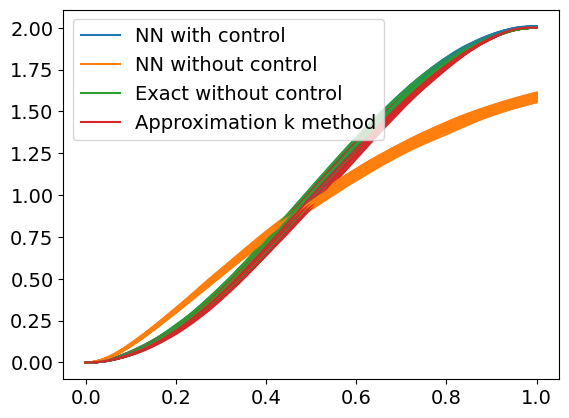

In [146]:
plt.figure()
for i in range(50):
    if i==0:
        plt.plot(t, X_pred_u[:,i,0].detach().numpy(), label = 'NN with control', color = 'C0')
        plt.plot(t, X_pred[:,i,0].detach().numpy(), label = 'NN without control', color = 'C1')
        plt.plot(t, X_pred_sol[:,i,0].detach().numpy(), label = 'Exact without control', color = 'C2')
        plt.plot(t, X_pred_k_approx[:,i,0].detach().numpy(), label = 'Approximation k method', color = 'C3')
        # plt.plot(t, X_pred_det[:,i,0].detach().numpy(), label = 'Deterministic'
    plt.plot(t, X_pred_u[:,i,0].detach().numpy(), color = 'C0')
    plt.plot(t, X_pred[:,i,0].detach().numpy(), color = 'C1')
    plt.plot(t, X_pred_sol[:,i,0].detach().numpy(), color = 'C2')
    plt.plot(t, X_pred_k_approx[:,i,0].detach().numpy(), color = 'C3')
    plt.legend()
    # plt.plot(t, X_pred_det[:,i,0].detach().numpy(), label = 'Deterministic')



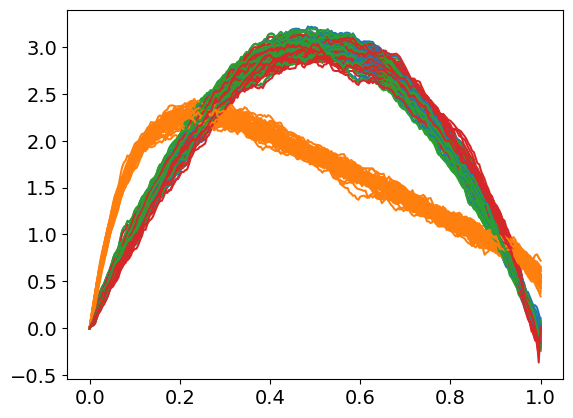

In [147]:
plt.figure()
for i in range(50):
    plt.plot(t, X_pred_u[:,i,1].detach().numpy(), label = 'NN with control', color = 'C0')
    plt.plot(t, X_pred[:,i,1].detach().numpy(), label = 'NN without control', color = 'C1')
    plt.plot(t, X_pred_sol[:,i,1].detach().numpy(), label = 'Exact without control', color = 'C2')
    plt.plot(t, X_pred_k_approx[:,i,1].detach().numpy(), label = 'Approximation k method', color = 'C3')

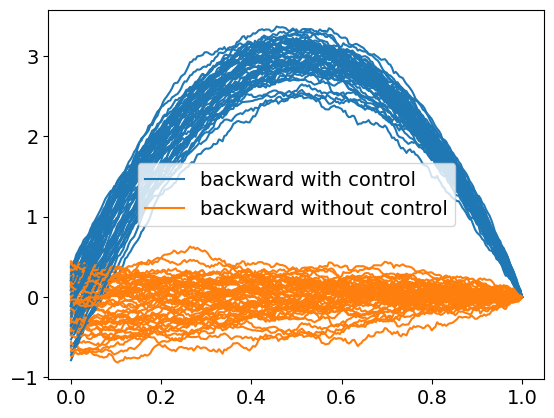

In [148]:
plt.figure()
for i in range(50):
    if i ==0:
        plt.plot(t, X_backward_u[:,i,1].detach().numpy(), label = 'backward with control', color = 'C0')
        plt.plot(t, X_backward[:,i,1].detach().numpy(), label = 'backward without control', color = 'C1')
    plt.plot(t, X_backward_u[:,i,1].detach().numpy(), color = 'C0')
    plt.plot(t, X_backward[:,i,1].detach().numpy(), color = 'C1')
    plt.legend()

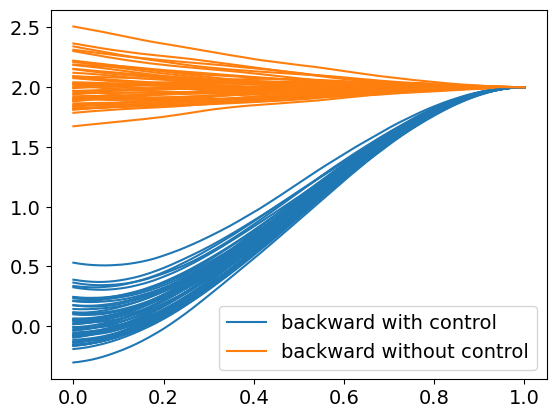

In [149]:
plt.figure()
for i in range(50):
    if i ==0:
        plt.plot(t, X_backward_u[:,i,0].detach().numpy(), label = 'backward with control', color = 'C0')
        plt.plot(t, X_backward[:,i,0].detach().numpy(), label = 'backward without control', color = 'C1')
    plt.plot(t, X_backward_u[:,i,0].detach().numpy(), color = 'C0')
    plt.plot(t, X_backward[:,i,0].detach().numpy(), color = 'C1')
    plt.legend()